In [26]:
import pandas as pd
from math import sqrt
import numpy as np

In [165]:
import matplotlib.pyplot as plt

In [64]:

from filterpy.monte_carlo import systematic_resample

In [63]:
import scipy

In [60]:
from statsmodels.distributions.empirical_distribution import ECDF

In [49]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [36]:
from kf_book import book_plots as book_plots

In [38]:
import kf_book.kf_internal as kf_internal

In [2]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])

In [3]:
df= pd.read_csv("data/ftx_book_snapshot_25_2020-01-01_BTC-PERP.csv.gz")

In [5]:
df['simple_mid'] = 0.5*(df['bids[0].price']+df['asks[0].price'])

<AxesSubplot:>

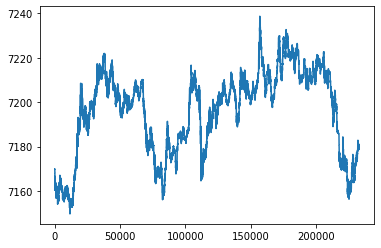

In [6]:
df['simple_mid'].plot()

In [7]:
def predict(price, ret):
    return gaussian(price.mean +ret.mean, price.var +ret.var)

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [10]:
## Test the predict
price = gaussian(100., 10**2)
ret = gaussian(0, 10**2)
predict(price, ret)

Gaussian(mean=100.0, var=200)

In [11]:
200**0.5


14.142135623730951

In [12]:
# test the update function
predicted_price = gaussian(100, 10**2)
measured_price = gaussian(110., 10**2)
estimated_price = update(predicted_price, measured_price)
estimated_price

Gaussian(mean=105.0, var=50.0)

In [28]:
class DogSimulation(object):
    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0,
                 process_var=0.0):
        """ x0 : initial position
            velocity: (+=right, -=left)
            measurement_var: variance in measurement m^2
            process_var: variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.meas_std = sqrt(measurement_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new position of the dog in dt seconds."""
        dx = self.velocity + np.random.randn()*self.process_std
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new position in meters."""
        measurement = self.x + np.random.randn()*self.meas_std
        return measurement

    def move_and_sense(self):
        """ Move dog, and return measurement of new position in meters"""
        self.move()
        return self.sense_position()

In [29]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)

In [30]:
zs = [dog.move_and_sense() for _ in range(10)]

In [31]:
zs

[-3.3410591564749654,
 1.0121021754353727,
 -4.29844318301781,
 0.3541772930711405,
 1.6468287212905204,
 3.6233375492028443,
 -3.100116621040282,
 1.7313751816875218,
 8.349971322200739,
 7.625301579756351]

	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	0.0000 0.0000 0.0000 0.0000 0.0000
	0.0000 0.0000 0.0000 0.0000 0.0000
	0.0000 0.0000 0.0000 0.0000 0.0000


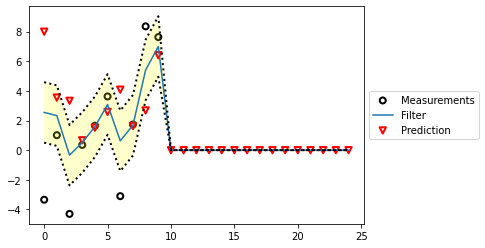

In [39]:
xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

In [40]:
xs

array([[ 2.54574719,  2.16227766],
       [ 2.32831519,  2.16227766],
       [-0.33638909,  2.16227766],
       [ 0.51492616,  2.16227766],
       [ 1.57830615,  2.16227766],
       [ 3.08045016,  2.16227766],
       [ 0.63014369,  2.16227766],
       [ 1.67878604,  2.16227766],
       [ 5.40382543,  2.16227766],
       [ 6.99075223,  2.16227766],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

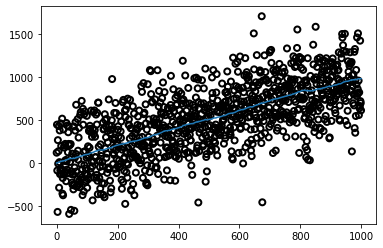

In [41]:
sensor_var = 300.**2
process_var = 2.
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 1000
dog = DogSimulation(pos.mean, 1., sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)

In [42]:
### Trying PArticle Filter

In [51]:
df['ret'] = df['simple_mid'].pct_change()


In [44]:
df['simple_mid']

0         7169.875
1         7169.875
2         7170.000
3         7170.000
4         7170.000
            ...   
233149    7178.875
233150    7178.875
233151    7179.375
233152    7179.375
233153    7179.375
Name: simple_mid, Length: 233154, dtype: float64

In [46]:
df.index = pd.to_datetime(df.timestamp, unit='us')

<AxesSubplot:>

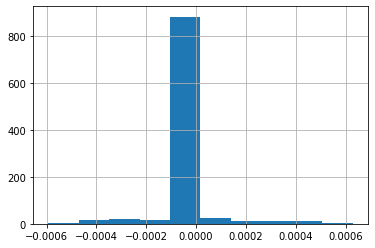

In [56]:
df['ret'].iloc[1:1000].hist()

In [59]:
## 1. Use first 1000 ticks as initial particles
inital_particle = df['ret'].iloc[1:1000].values

In [161]:
def predict(particles, mu, std, dt=1):
    return particles + np.random.randn(len(particles)) * std

def epdf_update(prev_z):
    return sm.nonparametric.KDEUnivariate(prev_z).fit()

def update(particles, weights, z, particle_std_err):
    current_ret = z
    weights *= scipy.stats.norm((particles - current_ret)**2).pdf(current_ret)
    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
    return weights

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    mean = np.average(particles, weights=weights, axis=0)
    var  = np.average((particles - mean)**2, weights=weights, axis=0)
    return mean, var

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes    
    return particles[indexes], weights.fill(1.0 / N)
def neff(weights):
    return 1. / np.sum(np.square(weights))
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))
    return weights

In [179]:
rets = df[df.ret!=0]['ret'].iloc[1:].values
particles = np.arange(-0.0015,0.0015, 0.00001)
N = len(particles)
roll_window = 1000
sensor_std_err = np.sqrt(N)*rets.std()
weights = np.ones(N) / N
xs=[]

for i in range(len(rets)-roll_window-1):
    if i < roll_window:
        pass
    else:
        rolling_obs = rets[i-roll_window:i]
        current_ret = rets[i]
        mu, std = particles.mean(), particles.std()
        weights = update(particles, weights, current_ret, sensor_std_err)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            weights = resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

In [174]:
rets

array([0.00000000e+00, 1.74340557e-05, 0.00000000e+00, ...,
       6.96487959e-05, 0.00000000e+00, 0.00000000e+00])

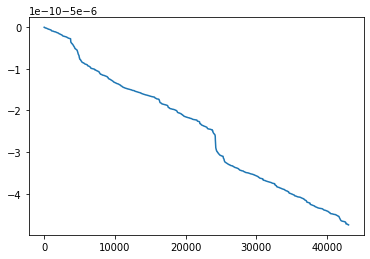

In [180]:
plt.plot(xs)

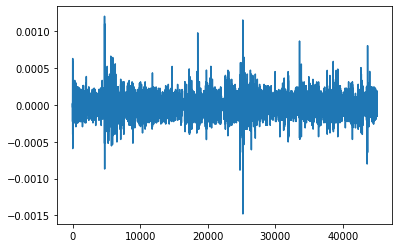

In [181]:
plt.plot(rets)

In [146]:
rets = df['ret'].iloc[1:].values
particles = np.arange(-1,1, 1e-5)
N = len(particles)
roll_window = 1000
sensor_std_err = 0.01

weights = np.ones(N) / N

timestamp
2020-01-01 00:00:02.139197         NaN
2020-01-01 00:00:02.240624    0.000000
2020-01-01 00:00:06.459690    0.000017
2020-01-01 00:00:06.533823    0.000000
2020-01-01 00:00:06.657532    0.000000
                                ...   
2020-01-01 23:59:58.233125    0.000000
2020-01-01 23:59:58.391667    0.000000
2020-01-01 23:59:59.050158    0.000070
2020-01-01 23:59:59.133443    0.000000
2020-01-01 23:59:59.333620    0.000000
Name: ret, Length: 233154, dtype: float64

In [83]:
current_ret

8.70337168619173e-05

In [124]:
weights = np.ones(roll_window) / roll_window
print(particles)
print(weights)
weights = update(particles, weights, current_ret, sensor_std_err)
print(weights)

weights /= sum(weights) # normalize

print(weights)

[ 0.00000000e+00  1.74340557e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.74337517e-05  0.00000000e+00  0.00000000e+00
 -1.74340557e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.74343596e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.74346636e-05
  0.00000000e+00 -1.74343596e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [157]:
current_ret=0
particles = np.arange(-1,1,0.1)
for p in particles:
    # print()
    print(f"p: {p} likelihood: {np.sqrt(2*np.pi)**(-1)* np.exp(-0.5*((current_ret-p))**2)} {scipy.stats.norm((p - current_ret)**2).pdf(current_ret)}")

p: -1.0 likelihood: 0.24197072451914337 0.24197072451914337
p: -0.9 likelihood: 0.2660852498987548 0.2873688969940283
p: -0.8 likelihood: 0.28969155276148273 0.3250622640840821
p: -0.7000000000000001 likelihood: 0.31225393336676127 0.3538123704977797
p: -0.6000000000000001 likelihood: 0.33322460289179967 0.37391060537312837
p: -0.5000000000000001 likelihood: 0.35206532676429947 0.38666811680284924
p: -0.40000000000000013 likelihood: 0.36827014030332333 0.3938683615685408
p: -0.30000000000000016 likelihood: 0.3813878154605241 0.39732983157868834
p: -0.20000000000000018 likelihood: 0.3910426939754559 0.39862325420460504
p: -0.1000000000000002 likelihood: 0.3969525474770118 0.39892233378608216
p: -2.220446049250313e-16 likelihood: 0.3989422804014327 0.3989422804014327
p: 0.09999999999999964 likelihood: 0.3969525474770118 0.39892233378608216
p: 0.19999999999999973 likelihood: 0.39104269397545594 0.39862325420460504
p: 0.2999999999999998 likelihood: 0.38138781546052414 0.39732983157868834
p

In [159]:
scipy.stats.norm((particles - current_ret)**2).pdf(current_ret)

array([0.24197072, 0.2873689 , 0.32506226, 0.35381237, 0.37391061,
       0.38666812, 0.39386836, 0.39732983, 0.39862325, 0.39892233,
       0.39894228, 0.39892233, 0.39862325, 0.39732983, 0.39386836,
       0.38666812, 0.37391061, 0.35381237, 0.32506226, 0.2873689 ])

In [152]:
len(particles)

200000

In [119]:
particles - np.ones(roll_window)*current_ret

array([ 0.00000000e+00,  1.74340557e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.74337517e-05,  0.00000000e+00,  0.00000000e+00,
       -1.74340557e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.74343596e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.74346636e-05,
        0.00000000e+00, -1.74343596e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [120]:
particles

array([ 0.00000000e+00,  1.74340557e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.74337517e-05,  0.00000000e+00,  0.00000000e+00,
       -1.74340557e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.74343596e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.74346636e-05,
        0.00000000e+00, -1.74343596e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [121]:
current_ret

0.0

In [110]:

scipy.stats.norm((particles - np.ones(roll_window)*current_ret)**2, 0.01).pdf(current_ret)

array([39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89422804,
       39.89422804, 39.89422804, 39.89422804, 39.89422804, 39.89

In [111]:

scipy.stats.norm((particles - np.ones(roll_window)*current_ret)**2, 0.01)

<AxesSubplot:>

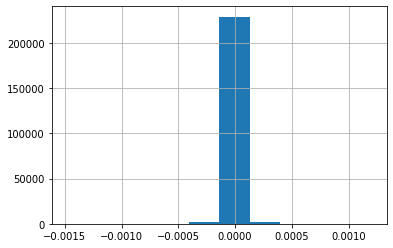

In [53]:
df.ret.hist()